# Module 4 Project

# 1 EDA

## 1.1 Importing Packages and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')
%matplotlib inline

In [2]:
links = pd.read_csv('./data/small/links.csv')

movies = pd.read_csv('./data/small/movies.csv')

ratings = pd.read_csv('./data/small/ratings.csv')

tags = pd.read_csv('./data/small/tags.csv')

## 1.2 Basic EDA

* How many unique users / movies?
* What are distributions of users / movies / ratings?

In [3]:
print("Unique users:", len(ratings.userId.unique()))

Unique users: 610


In [4]:
print("Unique films:", len(ratings.movieId.unique()))

Unique films: 9724


### 1.2.1 User Distribution

In [5]:
users = ratings.userId.unique()
user_counts = np.array([len(ratings[ratings.userId == Id]) for Id in users])
user_stats = pd.DataFrame()
user_stats['userId'] = users
user_stats['count'] = user_counts

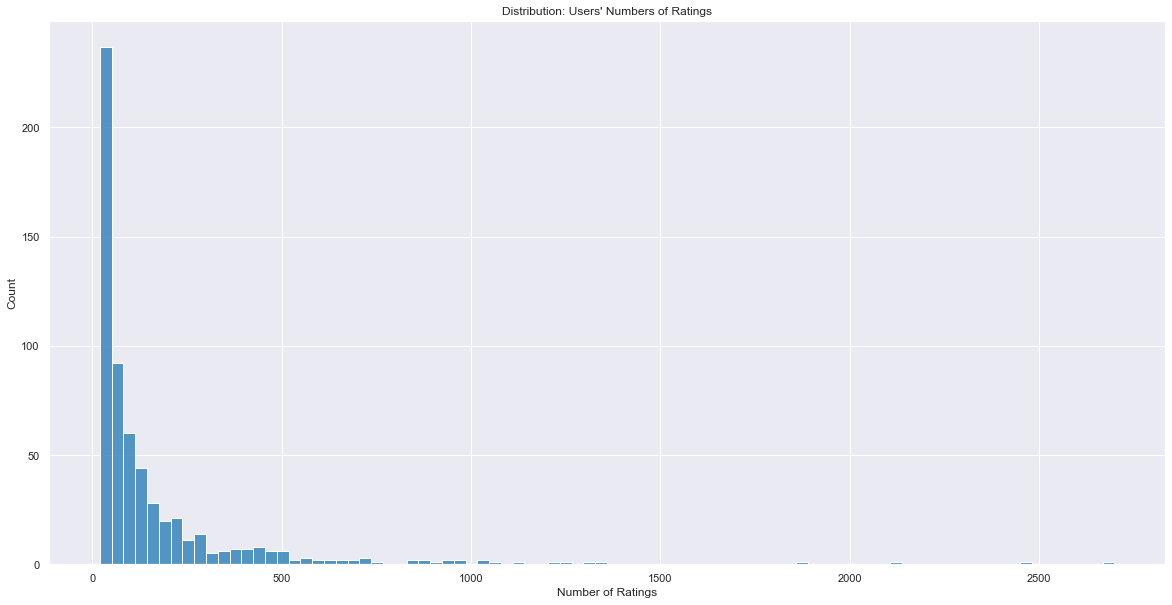

In [6]:
fig = plt.figure(figsize=(20,10))

ax = sns.histplot(data=user_stats, x='count')
ax.set_xlabel('Number of Ratings')
ax.set_title("Distribution: Users' Numbers of Ratings");

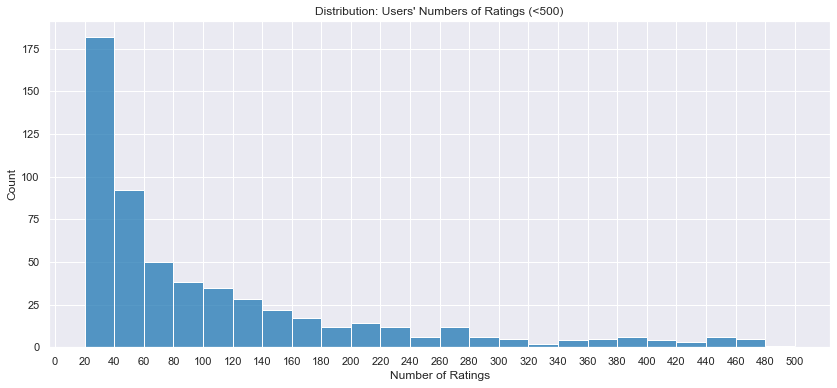

In [7]:
# So most users have less than 500 ratings
# Since there are a lot of very high outliers, let's look at users with <= 500 ratings

fig = plt.figure(figsize=(14,6))

ax = sns.histplot(data=user_stats[user_stats['count'] < 501], x='count', bins=24)
ax.set_xlabel('Number of Ratings')
ax.set_title("Distribution: Users' Numbers of Ratings (<500)")
ax.set_xticks(list(range(0, 501, 20)));

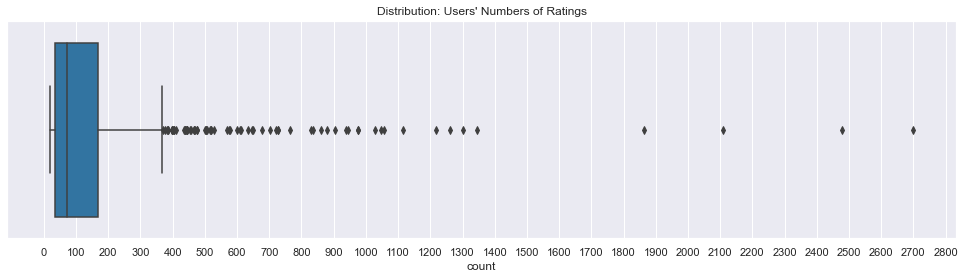

In [8]:
fig = plt.figure(figsize=(17, 4))

ax = sns.boxplot(data=user_stats, x='count')
ax.set_title("Distribution: Users' Numbers of Ratings")
ax.set_xticks(range(0,2801,100));

### 1.2.2 Movie Distribution

In [9]:
uniq_movies = ratings.movieId.unique()
movie_counts = np.array([len(ratings[ratings.movieId == Id]) for Id in uniq_movies])
movie_stats = pd.DataFrame()
movie_stats['movieId'] = uniq_movies
movie_stats['count'] = movie_counts

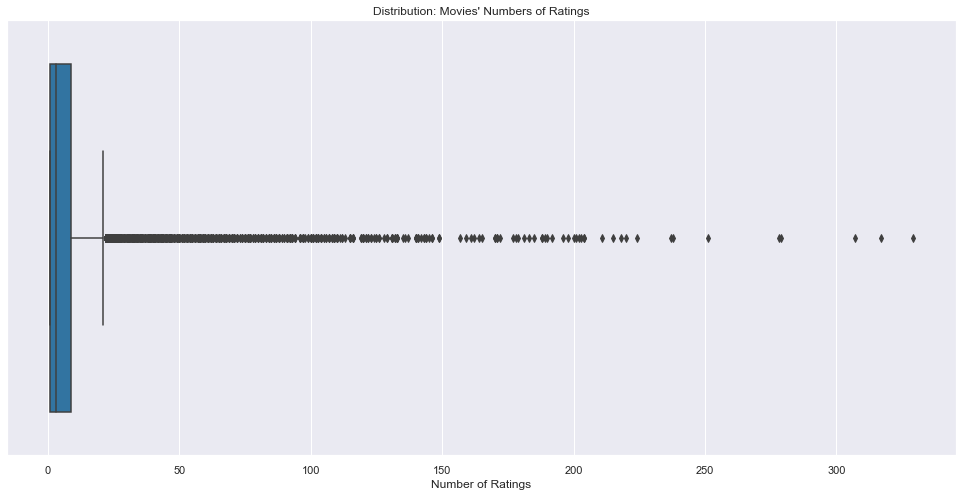

In [10]:
fig = plt.figure(figsize=(17,8))

ax = sns.boxplot(data=movie_stats, x='count')
ax.set_xlabel('Number of Ratings')
ax.set_title("Distribution: Movies' Numbers of Ratings");

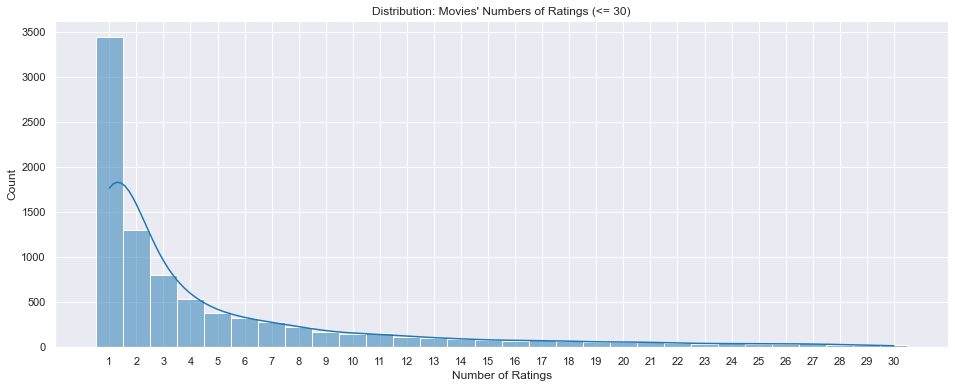

In [11]:
fig = plt.figure(figsize=(16,6))

ax = sns.histplot(data=movie_stats[movie_stats['count'] <= 30], x='count', discrete=True, kde=True)
ax.set_xlabel('Number of Ratings')
ax.set_title("Distribution: Movies' Numbers of Ratings (<= 30)")
ax.set_xticks(range(1,31));

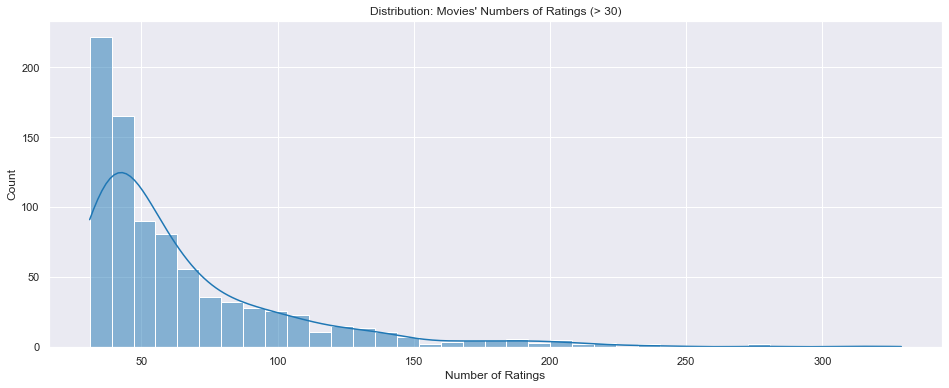

In [12]:
fig = plt.figure(figsize=(16,6))

ax = sns.histplot(data=movie_stats[movie_stats['count'] > 30], x='count', kde=True)
ax.set_xlabel('Number of Ratings')
ax.set_title("Distribution: Movies' Numbers of Ratings (> 30)");
#ax.set_xticks(range(1,31));

### 1.2.3 Movies' Mean Ratings Distribution

In [13]:
movie_avgs = [np.mean(ratings[ratings['movieId'] == Id]['rating']) for Id in uniq_movies]

In [14]:
movie_stats['mean_rating'] = movie_avgs

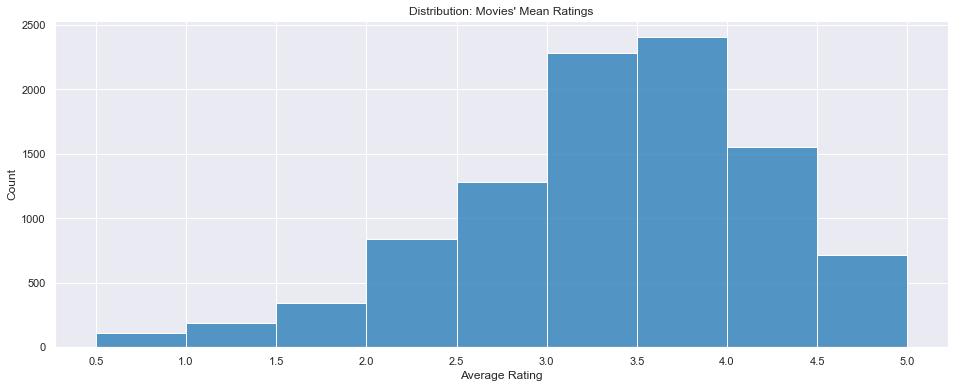

In [15]:
fig = plt.figure(figsize=(16,6))

ax = sns.histplot(data=movie_stats, x='mean_rating', bins=9)
ax.set_xlabel('Average Rating')
ax.set_title("Distribution: Movies' Mean Ratings")
ax.set_xticks([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]);

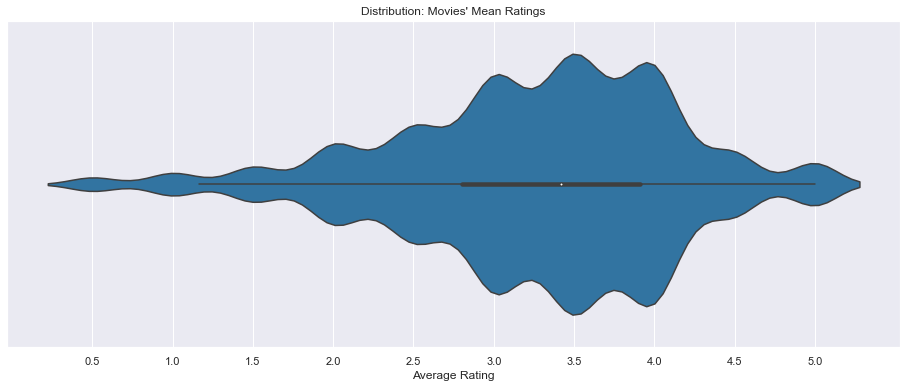

In [16]:
fig = plt.figure(figsize=(16,6))

ax = sns.violinplot(data=movie_stats, x='mean_rating')
ax.set_xlabel('Average Rating')
ax.set_title("Distribution: Movies' Mean Ratings")
ax.set_xticks([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]);

In [17]:
movie_stats.sort_values(by='count', ascending=False)

,movieId,count,mean_rating
20,356,329,4.164134
232,318,317,4.429022
16,296,307,4.197068
34,593,279,4.161290
166,2571,278,4.192446
...,...,...,...
6825,86279,1,3.500000
6826,86922,1,4.000000
857,5962,1,1.000000
6829,87660,1,4.500000


### 1.2.4 Ratings Distribution

In [18]:
rating_stats = pd.DataFrame()
rating_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
rating_stats['rating'] = rating_values
rating_counts = [len(ratings[ratings['rating']==rating]) for rating in rating_values]
rating_stats['count'] = rating_counts

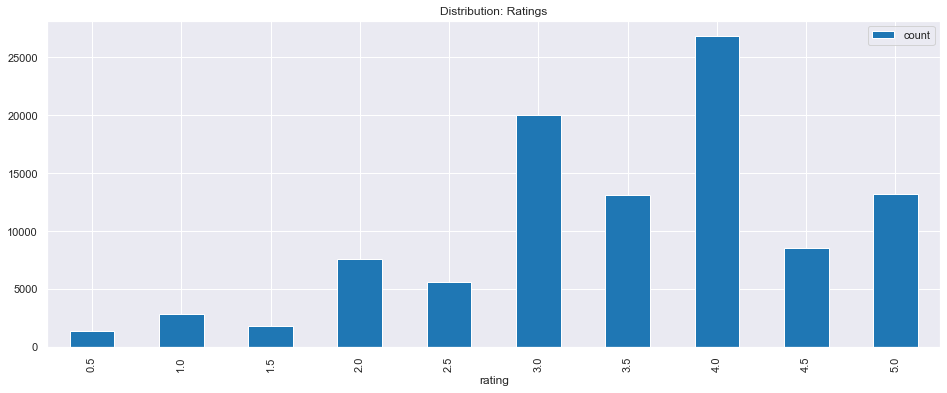

In [19]:
ax = rating_stats.plot(kind='bar', x='rating', y='count', figsize=(16, 6))
ax.set_title('Distribution: Ratings');

In [20]:
def movie_by_id(Id, movie_df):
    return list(movie_df[movie_df['movieId']==Id].title)[0]

movie_by_id(34, movies)

'Babe (1995)'

In [21]:
# Top 20 most-rated

most_rated = movie_stats.sort_values(by='count', ascending=False)

i = 0
while i < 20:
    print(f"#{i+1}:", movie_by_id(most_rated.iloc[i].movieId, movies), "\t", most_rated.iloc[i]['count'], "|",\
          round(most_rated.iloc[i].mean_rating, 1))
    i += 1

#1: Forrest Gump (1994) 	 329.0 | 4.2
#2: Shawshank Redemption, The (1994) 	 317.0 | 4.4
#3: Pulp Fiction (1994) 	 307.0 | 4.2
#4: Silence of the Lambs, The (1991) 	 279.0 | 4.2
#5: Matrix, The (1999) 	 278.0 | 4.2
#6: Star Wars: Episode IV - A New Hope (1977) 	 251.0 | 4.2
#7: Jurassic Park (1993) 	 238.0 | 3.8
#8: Braveheart (1995) 	 237.0 | 4.0
#9: Terminator 2: Judgment Day (1991) 	 224.0 | 4.0
#10: Schindler's List (1993) 	 220.0 | 4.2
#11: Fight Club (1999) 	 218.0 | 4.3
#12: Toy Story (1995) 	 215.0 | 3.9
#13: Star Wars: Episode V - The Empire Strikes Back (1980) 	 211.0 | 4.2
#14: American Beauty (1999) 	 204.0 | 4.1
#15: Usual Suspects, The (1995) 	 204.0 | 4.2
#16: Seven (a.k.a. Se7en) (1995) 	 203.0 | 4.0
#17: Independence Day (a.k.a. ID4) (1996) 	 202.0 | 3.4
#18: Apollo 13 (1995) 	 201.0 | 3.8
#19: Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) 	 200.0 | 4.2
#20: Lord of the Rings: The Fellowship of the Ring, The (2001) 	 198.0 | 4.1


In [22]:
# Top 20 highest-rated (with >= 5 ratings)

highest_rated = movie_stats[movie_stats['count'] >= 5].sort_values(by='mean_rating', ascending=False)

i = 0
while i < 20:
    print(f"#{i+1}:", movie_by_id(highest_rated.iloc[i].movieId, movies), "\t", highest_rated.iloc[i]['count'], "|",\
          round(highest_rated.iloc[i].mean_rating, 1))
    i += 1

#1: Trial, The (Procès, Le) (1962) 	 5.0 | 4.9
#2: Three Billboards Outside Ebbing, Missouri (2017) 	 8.0 | 4.8
#3: Memories of Murder (Salinui chueok) (2003) 	 5.0 | 4.7
#4: Swept Away (Travolti da un insolito destino nell'azzurro mare d'Agosto) (1975) 	 6.0 | 4.7
#5: Yi Yi (2000) 	 5.0 | 4.6
#6: Secrets & Lies (1996) 	 11.0 | 4.6
#7: Day of the Doctor, The (2013) 	 7.0 | 4.6
#8: Guess Who's Coming to Dinner (1967) 	 11.0 | 4.5
#9: Paths of Glory (1957) 	 12.0 | 4.5
#10: Paris Is Burning (1990) 	 5.0 | 4.5
#11: Man Bites Dog (C'est arrivé près de chez vous) (1992) 	 6.0 | 4.5
#12: Five Easy Pieces (1970) 	 8.0 | 4.5
#13: Captain Fantastic (2016) 	 5.0 | 4.5
#14: Jules and Jim (Jules et Jim) (1961) 	 5.0 | 4.5
#15: Last Tango in Paris (Ultimo tango a Parigi) (1972) 	 5.0 | 4.5
#16: Last Picture Show, The (1971) 	 8.0 | 4.5
#17: Streetcar Named Desire, A (1951) 	 20.0 | 4.5
#18: Celebration, The (Festen) (1998) 	 12.0 | 4.5
#19: Ran (1985) 	 15.0 | 4.4
#20: Shawshank Redemption, The (19

In [23]:
# Top 20 lowest-rated (>= 5 ratings)

lowest_rated = movie_stats[movie_stats['count'] >= 5].sort_values(by='mean_rating', ascending=True)

i = 0
while i < 20:
    print(f"#{i+1}:", movie_by_id(lowest_rated.iloc[i].movieId, movies), "\t", lowest_rated.iloc[i]['count'], "|",\
          round(lowest_rated.iloc[i].mean_rating, 1))
    i += 1

#1: Police Academy: Mission to Moscow (1994) 	 5.0 | 0.8
#2: Jason X (2002) 	 8.0 | 1.2
#3: When a Stranger Calls (2006) 	 5.0 | 1.3
#4: Problem Child 2 (1991) 	 8.0 | 1.3
#5: Catwoman (2004) 	 9.0 | 1.3
#6: Spice World (1997) 	 10.0 | 1.4
#7: Ernest Goes to Camp (1987) 	 5.0 | 1.4
#8: Jaws 3-D (1983) 	 6.0 | 1.4
#9: Stuart Saves His Family (1995) 	 9.0 | 1.4
#10: Beethoven's 2nd (1993) 	 5.0 | 1.5
#11: Eye of the Beholder (1999) 	 6.0 | 1.6
#12: Ladies Man, The (2000) 	 6.0 | 1.6
#13: My Super Ex-Girlfriend (2006) 	 6.0 | 1.6
#14: Problem Child (1990) 	 12.0 | 1.6
#15: Look Who's Talking Now (1993) 	 6.0 | 1.6
#16: Pokémon the Movie 2000 (2000) 	 6.0 | 1.6
#17: Ghost Rider: Spirit of Vengeance (2012) 	 5.0 | 1.6
#18: Speed 2: Cruise Control (1997) 	 19.0 | 1.6
#19: Flintstones in Viva Rock Vegas, The (2000) 	 12.0 | 1.6
#20: Battlefield Earth (2000) 	 19.0 | 1.7


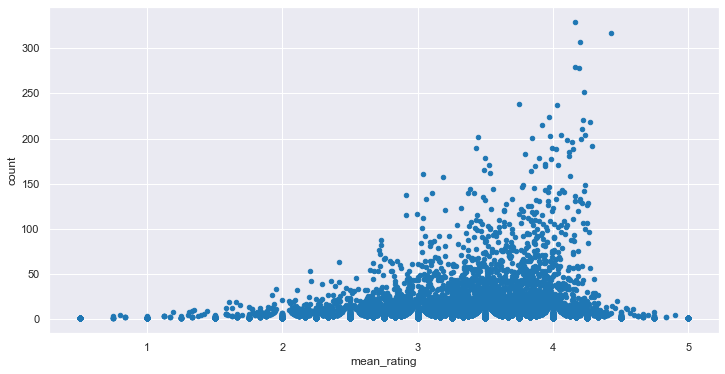

In [24]:
movie_stats.plot(kind='scatter', x='mean_rating', y='count', figsize=(12,6));

# 2. Modelling

Because of findings above:
* Since there are many films (1/3) with only 1 review, I'll subset and create a similiarly sized dataset from the 'full' dataset. I'd like to target:
    * A similar number of ratings as the 'small' dataset (100,000)
    * At least 20 ratings per user (as in the 'small' dataset)
    * At least 5 ratings per film, to weed out very rare/obscure films
    
    
* To evaluate the predictions, I'd like to use NDCG, which requires that we have relevance scores (in this case, ratings) and evaluate it in a ranked context. To achieve this, I'll subset the large set by:

    * Selecting a subset of users' ratings, for manageability
    * Selecting only ratings of movies with >= 5 ratings
    * Selecting only users with >= 20 ratings of these films
    * Subsetting based on these user/movie rating thresholds again to remove stragglers
    * Setting aside 5 ratings from each user as the Test Set
    * After building model on the remaining ratings, predict ratings for the Test Set movies
    * Finally, calculate NDCG for each user's set of 5 films and calculate mean NDCG across predictions

## 2.1 Data Subsetting

In [437]:
# load full dataset

movies_full = pd.read_csv('./data/full/movies.csv')

ratings_full = pd.read_csv('./data/full/ratings.csv')

In [438]:
good_titles = []
good_ids = []

i = 0

titles = list(movies_full.title)
movieIds = list(movies_full.movieId)

for i in range(len(titles)):
    if title:
        if titles[i][-1] == ')':
            if titles[i][-2].isdigit():
                good_titles.append(titles[i])
                good_ids.append(movieIds[i])
        elif titles[i][-2:-1] == ') ':
            if titles[i][-2].isdigit():
                good_titles.append(titles[i][:-1])
                good_ids.append(movieIds[i])

In [439]:
movies_full = movies_full[movies_full['movieId'].isin(good_ids)]
ratings_full = ratings_full[ratings_full['movieId'].isin(good_ids)]

In [440]:
userIds = ratings_full.userId.unique()
print("Number of unique users:", len(userIds))

Number of unique users: 283225


In [442]:
np.random.seed(42)
user_subset = np.random.choice(userIds, replace=False, size=1600)
ratings_subset = ratings_full[ratings_full['userId'].isin(user_subset)]
print("Length of initial subset:", len(ratings_subset))

Length of initial subset: 141082


In [443]:
def subsetter(df, u=20, m=5):
    """
    This function alternates subsetting the dataset by movie rating counts,
    and user rating counts, until it reaches the thresholds.
    
    As it loops, the function prints the type of subsetting and which loop it is on.
    
    Arguments:
        df: dataframe
        u: user rating count threshold (defautl: 20)
        m: movie rating count threshold (default: 5)
    
    Returns:
        subset: subsetted dataframe
    """
    subset = df.copy()
    i = 0
    while ((subset.userId.value_counts().min() < u) or (subset.movieId.value_counts().min() < m)):
        if subset.movieId.value_counts().min() < m:
            print(f"Subsetting by movies, round {i+1}")
            enough = []
            for movie in subset.movieId.unique():
                if len(subset[subset['movieId']==movie]) >= m:
                    enough.append(movie)
            subset = subset[subset['movieId'].isin(enough)]
        if subset.userId.value_counts().min() < u:
            print(f"Subsetting by users, round {i+1}")
            enough = []
            for user in subset.userId.unique():
                if len(subset[subset['userId']==user]) >= u:
                    enough.append(user)
            subset = subset[subset['userId'].isin(enough)]
        i += 1
    return subset

In [444]:
def create_stats(df):
    """
    This function creates two 'stats' dataframes, with count data for each movie and user.
    
    Argument:
        df: dataframe
    
    Returns:
        movie_stats_df, user_stats_df: dataframes with columns for Id (user or movie), and count
    """
    uniq_movies = df.movieId.unique()
    movie_counts = np.array([len(df[df.movieId == Id]) for Id in uniq_movies])
    movie_stats_df = pd.DataFrame()
    movie_stats_df['movieId'] = uniq_movies
    movie_stats_df['count'] = movie_counts

    users = df.userId.unique()
    user_counts = np.array([len(df[df.userId == Id]) for Id in users])
    user_stats_df = pd.DataFrame()
    user_stats_df['userId'] = users
    user_stats_df['count'] = user_counts
    
    return movie_stats_df, user_stats_df

In [445]:
final_subset = subsetter(ratings_subset)

Subsetting by movies, round 1
Subsetting by users, round 1
Subsetting by movies, round 2


In [446]:
final_movie_stats, final_user_stats = create_stats(final_subset)
display(final_movie_stats.sort_values(by='count').head())
display(final_user_stats.sort_values(by='count').head())

,movieId,count
4060,58627,5
3276,1809,5
3266,212,5
3265,93,5
3262,747,5


,userId,count
875,260555,20
585,174979,20
728,216258,20
536,159917,20
639,190641,20


In [447]:
# So we have successfully created the subsetted dataframe, with at least 5 ratings per movie,
# and 20 ratings per user.

# Let's check some stats to confirm it's similar to the 'small' dataset otherwise:

In [448]:
print("Unique films:", len(final_movie_stats))
print("Unique users:", len(final_user_stats))

Unique films: 4061
Unique users: 953


In [449]:
print("Total ratings:", len(final_subset))

Total ratings: 122111


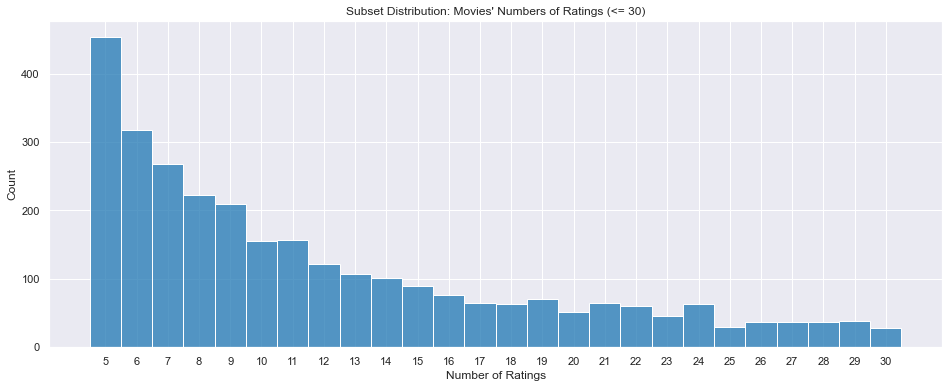

In [450]:
fig = plt.figure(figsize=(16,6))

ax = sns.histplot(data=final_movie_stats[final_movie_stats['count'] <= 30], x='count', discrete=True)
ax.set_xlabel('Number of Ratings')
ax.set_title("Subset Distribution: Movies' Numbers of Ratings (<= 30)")
ax.set_xticks(range(5,31));

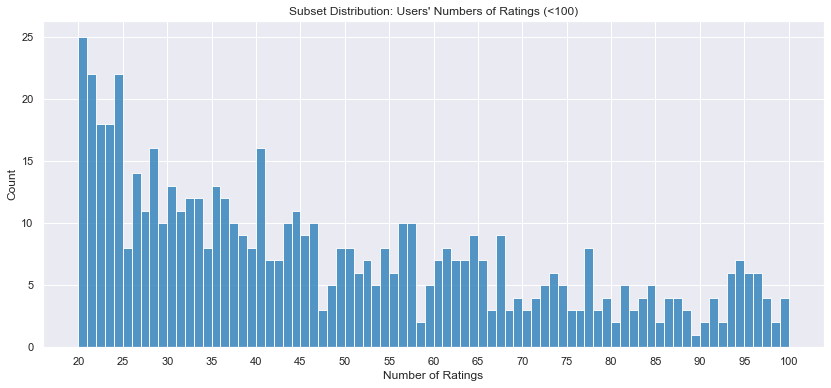

In [451]:
fig = plt.figure(figsize=(14,6))

ax = sns.histplot(data=final_user_stats[final_user_stats['count'] < 101], x='count', bins=80)
ax.set_xlabel('Number of Ratings')
ax.set_title("Subset Distribution: Users' Numbers of Ratings (<100)")
ax.set_xticks(list(range(20, 101, 5)));

In [452]:
final_ratings = final_subset.drop('timestamp', axis=1).copy()
final_movies = movies_full[movies_full['movieId'].isin(final_movie_stats.movieId)].copy()

In [453]:
from sklearn.model_selection import train_test_split

def split_df(df, n=4, seed=1):
    userIds = df.userId.unique()
    
    ratings_train = pd.DataFrame()
    ratings_test = pd.DataFrame()
    
    for userId in userIds:
        user_df = df[df['userId']==userId]
        shuffled = user_df.sample(frac=1, random_state=seed)
        result = np.array_split(shuffled, n)

        ratings_train = pd.concat([ratings_train]+result[:-1])
        ratings_test = pd.concat([ratings_test, result[-1]])

        seed += 1
    return ratings_train, ratings_test

In [454]:
ratings_train, ratings_test = split_df(final_ratings)

len(ratings_train), len(ratings_test)

(91916, 30195)

In [455]:
ratings_train.to_csv('./data/ratings_train.csv')
ratings_test.to_csv('./data/ratings_test.csv')
final_ratings.to_csv('./data/ratings_full.csv')
final_movies.to_csv('./data/movies_final.csv')

## 2.2 Create Model

In [456]:
# import necessary libraries
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('RecSys')\
    .config('spark.driver.host', 'localhost')\
    .getOrCreate()

In [457]:
movies = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load('./data/movies_final.csv')

train = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load('./data/ratings_train.csv')

test = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load('./data/ratings_test.csv')

ratings_full = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load('./data/ratings_full.csv')

In [458]:
train_df = train.toPandas()

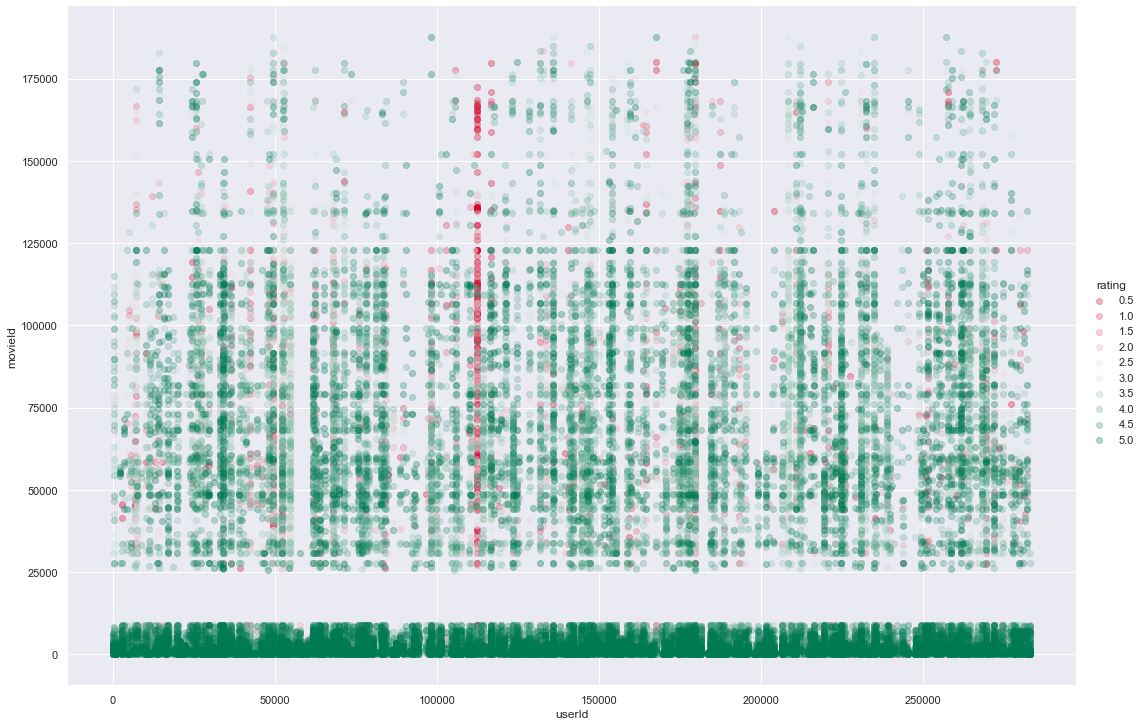

In [459]:
sns.lmplot(x="userId", y="movieId", hue="rating", data=train_df,\
           fit_reg=False, height=10, aspect=1.5, scatter_kws={'alpha':0.3},\
           palette=sns.diverging_palette(10, 150, s=100, l=45, sep=1, n=10));

In [460]:
from pyspark.ml.recommendation import ALS
model = ALS(userCol="userId",itemCol="movieId",ratingCol="rating").fit(train)

In [461]:
predictions = model.transform(test)
predictions.show();

+--------+------+-------+------+----------+
|     _c0|userId|movieId|rating|prediction|
+--------+------+-------+------+----------+
| 4053816| 41696|    471|   5.0| 3.6443007|
| 2769191| 28640|    471|   4.5| 3.7551003|
| 2030785| 20808|    471|   4.0| 3.2283945|
|17760643|181576|    471|   5.0|  3.575389|
| 4991080| 51262|    471|   3.0|  3.574467|
|14658784|149946|    471|   3.0| 3.4087389|
| 8130616| 83615|    471|   4.0| 2.7748594|
|22743215|232396|    471|   4.0| 3.5080237|
|18449120|188160|    471|   3.0| 2.9924312|
|15190405|155210|    471|   4.0|  3.365204|
|22986353|234990|    471|   4.0| 3.5808225|
| 1136418| 11360|    471|   4.0| 3.6152108|
|10469209|107633|    471|   5.0| 3.9995222|
| 3327393| 34204|    471|   4.0| 3.8193524|
| 1810749| 18559|    471|   5.0| 4.0395894|
|13863817|141927|    471|   4.0|  3.665038|
|14324772|146589|    471|   4.0|  3.616495|
|25313765|258607|    833|   2.0|  2.907283|
|27737877|283040|    833|   5.0| 3.3968406|
|18939952|193284|   1088|   4.0|

In [462]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(metricName="rmse",labelCol="rating",predictionCol="prediction")
print("the root mean squared error is:", str(evaluator.evaluate(predictions.na.drop())))

the root mean squared error is: 0.8719046174117576


In [463]:
import numpy as np
def repeatALS (data, k, userCol="userId", itemCol="movieId", ratingCol="rating", metricName="rmse"):
    evaluations = []
    for i in range(1,k+1):
        data_df = data.toPandas()
        tr_df, ts_df = split_df(data_df, seed=i)
        tr = spark.createDataFrame(tr_df)
        ts = spark.createDataFrame(ts_df)
        model = ALS(userCol=userCol, itemCol=itemCol, ratingCol=ratingCol,).fit(tr)
        predictions = model.transform(ts)
        
        evaluator = RegressionEvaluator(metricName=metricName, labelCol="rating", predictionCol="prediction")
        evaluation = evaluator.evaluate(predictions.na.drop())
        
        print("Loop", str(i)+":", metricName, "=", str(evaluation))
        
        evaluations.append(evaluation)
    return np.mean(evaluations)

In [464]:
repeatALS(ratings_full, k=4)

Loop 1: rmse = 0.8719046174117576
Loop 2: rmse = 0.8727483916155852
Loop 3: rmse = 0.8712706761947668
Loop 4: rmse = 0.8647155266758533


0.8701598029744908

In [466]:
evaluations = []
best = 5
best_params = []
for rank in [1, 20, 50]:
    for reg in [1, .1, .01]:
        print(f"Rank({rank}) reg({reg}) fitting...")
        model = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",\
                    rank=rank, maxIter=20, regParam=reg).fit(train)
        predictions = model.transform(test)
        
        evaluator = RegressionEvaluator(metricName='rmse', labelCol="rating", predictionCol="prediction")
        evaluation = evaluator.evaluate(predictions.na.drop())
        
        print(f"Rank({rank}) reg({reg})", 'rmse', "=", str(evaluation))
        
        evaluations.append(evaluation)
        
        if evaluation < best:
            best = evaluation
            best_params = [rank, reg]
print(np.min(evaluations))
print(f"Rank: {best_params[0]}, Reg: {best_params[1]}")

Rank(1) reg(1) fitting...
Rank(1) reg(1) rmse = 1.3218195482877917
Rank(1) reg(0.1) fitting...
Rank(1) reg(0.1) rmse = 0.8802640823016664
Rank(1) reg(0.01) fitting...
Rank(1) reg(0.01) rmse = 0.8757077371530552
Rank(1) reg(0.001) fitting...
Rank(1) reg(0.001) rmse = 0.8758174231434842
Rank(20) reg(1) fitting...
Rank(20) reg(1) rmse = 1.3218195522964449
Rank(20) reg(0.1) fitting...
Rank(20) reg(0.1) rmse = 0.8677028351091811
Rank(20) reg(0.01) fitting...
Rank(20) reg(0.01) rmse = 1.1883352141330843
Rank(20) reg(0.001) fitting...
Rank(20) reg(0.001) rmse = 1.5020400102650964
Rank(50) reg(1) fitting...
Rank(50) reg(1) rmse = 1.3218195525909069
Rank(50) reg(0.1) fitting...
Rank(50) reg(0.1) rmse = 0.8592777178098381
Rank(50) reg(0.01) fitting...
Rank(50) reg(0.01) rmse = 1.198611846874396
Rank(50) reg(0.001) fitting...
Rank(50) reg(0.001) rmse = 1.5759741693461697
Rank(100) reg(1) fitting...
Rank(100) reg(1) rmse = 1.3218195465430282
Rank(100) reg(0.1) fitting...
Rank(100) reg(0.1) rmse = 

In [473]:
best_model = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",\
                rank=100, regParam=0.1, maxIter=20).fit(train)

pred_test = model.transform(test)
pred_train = model.transform(train)

In [474]:
final_user_stats.sort_values('count')

,userId,count
875,260555,20
585,174979,20
728,216258,20
536,159917,20
639,190641,20
...,...,...
153,49534,1179
314,98157,1203
775,231014,1225
0,239,1271


In [529]:
pred_test_df = pred_test.toPandas()
pred_train_df = pred_train.toPandas()
userIds = list(pred_df.userId.unique())

In [575]:
import math
def dcg(values, k):
    dcg=0
    for i in range(k):
        dcg=dcg+values[i]/math.log(i+2,2)
    return dcg

In [619]:
NDCG = []

for i in range(len(userIds)):
    user_test_df = pred_test_df[pred_test_df['userId']==userId]
    user_train_df = pred_train_df[pred_train_df['userId']==userId]
    user_df = pd.concat([user_test_df, user_train_df])
    userId = userIds[i]
    
    l1_df = user_df.sort_values(by='prediction', ascending=False)
    l2_df = user_df.sort_values(by='rating', ascending=False)
    l1 = np.array(l1_df['rating'])
    l2 = np.array(l2_df['rating'])
    
    k = int(len(l1)/2) - 1
    ndcg = dcg(l1, k) / dcg(l2, k)
    NDCG.append(ndcg)
    
ndcg_mean = np.mean(NDCG)
ndcg_max = np.max(NDCG)
ndcg_min = np.min(NDCG)

In [620]:
print(ndcg_mean, ndcg_max, ndcg_min)

0.9743961563354342 1.0 0.8166675527577225


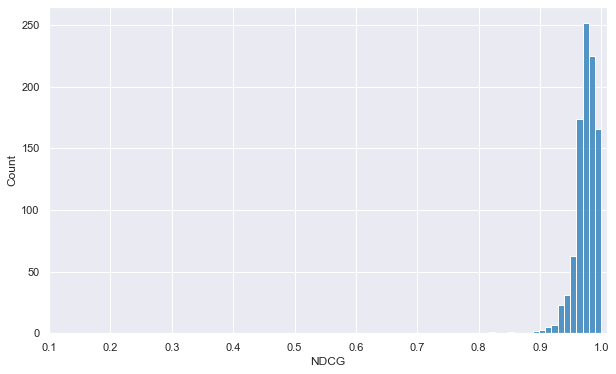

In [621]:
plt.figure(figsize=(10,6))
ax = sns.histplot(NDCG, bins=18)
ax.set_xticks([.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
ax.set_xlabel('NDCG');

In [622]:
NDCG = []

for i in range(len(userIds)):
    user_test_df = pred_test_df[pred_test_df['userId']==userId]
    user_train_df = pred_train_df[pred_train_df['userId']==userId]
    user_df = pd.concat([user_test_df, user_train_df])
    userId = userIds[i]
    
    l1_df = user_df.sample(frac=1, random_state=i+1)
    l2_df = user_df.sort_values(by='rating', ascending=False)
    l1 = list(l1_df['rating'])
    l2 = list(l2_df['rating'])
    
    k = int(len(l1)/2) - 1
    ndcg = dcg(l1, k) / dcg(l2, k)
    NDCG.append(ndcg)
    
ndcg_mean = np.mean(NDCG)
ndcg_max = np.max(NDCG)
ndcg_min = np.min(NDCG)

In [623]:
print(ndcg_mean, ndcg_max, ndcg_min)

0.8098995683777399 1.0 0.3606934189444156


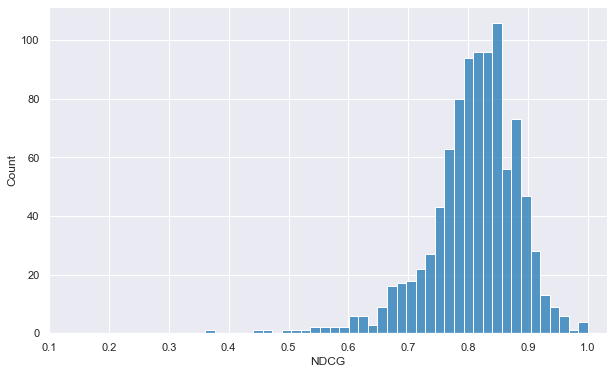

In [624]:
plt.figure(figsize=(10,6))
ax = sns.histplot(NDCG)
ax.set_xticks([.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
ax.set_xlabel('NDCG');

In [614]:
movieId_means = {}
for movieId in pred_train_df.movieId.unique():
    sub_df = ratings_train[ratings_train['movieId']==movieId]
    movieId_means[movieId] = sub_df['rating'].mean()

pred_test_df['movie_avg_rating'] = [movieId_means[movieId] for movieId in pred_test_df['movieId']]
pred_train_df['movie_avg_rating'] = [movieId_means[movieId] for movieId in pred_train_df['movieId']]

In [625]:
NDCG = []

for i in range(len(userIds)):
    user_test_df = pred_test_df[pred_test_df['userId']==userId]
    user_train_df = pred_train_df[pred_train_df['userId']==userId]
    user_df = pd.concat([user_test_df, user_train_df])
    userId = userIds[i]
    
    l1_df = user_df.sort_values(by='movie_avg_rating', ascending=False)
    l2_df = user_df.sort_values(by='rating', ascending=False)
    l1 = list(l1_df['rating'])
    l2 = list(l2_df['rating'])
    
    k = int(len(l1)/2) - 1
    ndcg = dcg(l1, k) / dcg(l2, k)
    NDCG.append(ndcg)
    
ndcg_mean = np.mean(NDCG)
ndcg_max = np.max(NDCG)
ndcg_min = np.min(NDCG)

In [626]:
print(ndcg_mean, ndcg_max, ndcg_min)

0.8897867321502367 1.0 0.1729095306820655


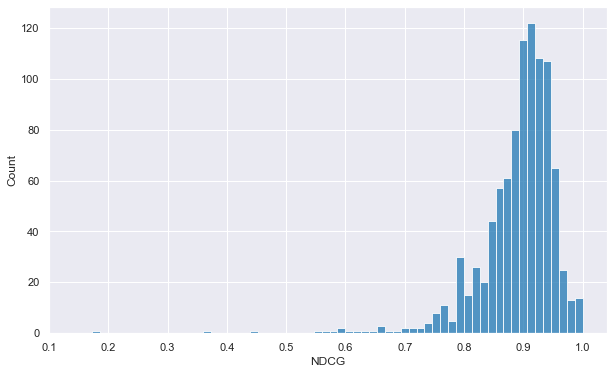

In [627]:
plt.figure(figsize=(10,6))
ax = sns.histplot(NDCG)
ax.set_xticks([.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
ax.set_xlabel('NDCG');

# 3. Implementation

In [618]:
final_movies = pd.read_csv('./data/movies_final.csv')
final_movies['year'] = [int(str(title[-5:-1])) for title in list(final_movies.copy().title)]
final_movies['genres'] = [[genre.lower() for genre in genres.split('|')] for genres in final_movies['genres']]

* Content-based filtering for new users:
    * Start with categories (genre, decade) mostly of movies with a certain number of reviews (such that they are popular enough and not too obscure)
    * Offer a fast-track movie-rating feature to build a profile quickly
* Recommend on-demand based on:
    * Genre
    * Decade
    * Popularity / Number of Ratings
* Recommend on the app side based on:
    * Recommend decades/genres by finding most-frequent or highest-recommended genres and decades in user profile